# Chapitre 06: Backtest with variations trade exit

### 6.1 Useful backtest advices
> ###### 6.1.1 Backtest is not a searching tool
> ###### 6.1.2 Big days are not your friends
> ###### 6.1.3 Understand your strategy

### 6.2 Compute the strategy returns using TP and SL
> ###### 6.2.1 Find the extremum
> ###### 6.2.2 Calculate the returns
> ###### 6.2.3 Analyze the backtest

### 6.3 Advanced backtest tools
> ###### 6.3.1 Backtest metrics list
> ###### 6.3.2 Monte Carlo simulation
> ###### 6.3.3 Easy Trailing stop

**Donner l'astuce pour le Backtest du TSL**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import warnings
warnings.filterwarnings("ignore")
import yfinance as yf
from tqdm import tqdm
import seaborn as sns
from scipy.optimize import minimize
from Backtest import *

### 6.2 Compute the strategy returns using TP and SL

**We can't extract enough little timeframe data using Yahoo finance. So we need to import them directly from the broker and it is the best thing to do to be as close as possible to the market!**

In [2]:
# Import data with different timeframes
df_highest_timeframe = pd.read_csv("ADAUSDT-1h.csv", index_col="Unnamed: 0", parse_dates=True)
df_lowest_timeframe = pd.read_csv("ADAUSDT-5m.csv", index_col="Unnamed: 0", parse_dates=True)

###### 6.2.1 Find the extremum

In [3]:
def find_timestamp_extremum(data, df_lowest_timeframe):
    """
    :params: data(highest timeframe OHLCV data), df_lowest_timeframe (lowest timeframe OHLCV data)
    :return: data with three new columns: Low_time (TimeStamp), High_time (TimeStamp), High_first (Boolean)
    """

    # Set new columns
    data["Low_time"] = np.nan
    data["High_time"] = np.nan
    data["First"] = np.nan


    # Loop to find out which of the Take Profit and Stop loss appears first
    for i in tqdm(range(len(data) - 1)):

        # Extract values from the lowest timeframe dataframe
        start = data.iloc[i:i + 1].index[0]
        end = data.iloc[i + 1:i + 2].index[0]
        row_lowest_timeframe = df_lowest_timeframe.loc[start:end].iloc[:-1]

        # Extract Timestamp of the max and min over the period (highest timeframe)
        try:
            high = row_lowest_timeframe["high"].idxmax()
            low = row_lowest_timeframe["low"].idxmin()

            data.loc[start, "Low_time"] = low
            data.loc[start, "High_time"] = high

        except Exception as e:
            print(e)
            data.loc[start, "Low_time"] = start
            data.loc[start, "High_time"] = start

    # Find out which appears first
    data.loc[data["High_time"] > data["Low_time"], "First"] = 1
    data.loc[data["High_time"] < data["Low_time"], "First"] = 2
    data.loc[data["High_time"] == data["Low_time"], "First"] = 0


    # Verify the number of row without both TP and SL on same time
    percentage_garbage_row = len(data.loc[data["First"]==0].dropna()) / len(data) * 100

    #if percentage_garbage_row<95:
    print(f"WARNINGS: Garbage row: {'%.2f' % percentage_garbage_row} %")

    
    # Transform the columns in datetime columns
    data.High_time = pd.to_datetime(data.High_time)
    data.Low_time = pd.to_datetime(data.Low_time)
    
    # We delete the last row because we can't find the extremum
    data = data.iloc[:-1]
    
    # Specific to the current data 
    if "timestamp" is data.columns:
        del data["timestamp"]
        
    return data

In [4]:
df = find_timestamp_extremum(df_highest_timeframe, df_lowest_timeframe)
df

 78%|███████████████████████████▏       | 26864/34566 [00:08<00:02, 3086.10it/s]

attempt to get argmax of an empty sequence


100%|███████████████████████████████████| 34566/34566 [00:11<00:00, 3056.52it/s]

WARNINGS: Garbage row: 0.86 %


,timestamp,open,high,low,close,volume,Low_time,High_time,First
2018-04-17 04:00:00,2018-04-17 04:00:00,0.25551,0.28800,0.25551,0.26664,8143693.23,2018-04-17 04:00:00,2018-04-17 04:05:00,1.0
2018-04-17 05:00:00,2018-04-17 05:00:00,0.26660,0.27798,0.26010,0.26200,8317923.61,2018-04-17 05:55:00,2018-04-17 05:05:00,2.0
2018-04-17 06:00:00,2018-04-17 06:00:00,0.26221,0.26396,0.24800,0.25664,8420095.41,2018-04-17 06:30:00,2018-04-17 06:00:00,2.0
2018-04-17 07:00:00,2018-04-17 07:00:00,0.25662,0.26300,0.25489,0.25698,4686043.91,2018-04-17 07:00:00,2018-04-17 07:30:00,1.0
2018-04-17 08:00:00,2018-04-17 08:00:00,0.25636,0.25998,0.25229,0.25631,3510038.13,2018-04-17 08:10:00,2018-04-17 08:40:00,1.0
...,...,...,...,...,...,...,...,...,...
2022-03-30 19:00:00,2022-03-30 19:00:00,1.19800,1.20300,1.18300,1.19300,10494867.40,2022-03-30 19:50:00,2022-03-30 19:10:00,2.0
2022-03-30 20:00:00,2022-03-30 20:00:00,1.19400,1.20200,1.19000,1.20100,4851374.00,2022-03-30 20:00:00,2022-03-30 20:50:00,1.0
2022-03-30 21:00:00,2022-03-30 21:00:00,1.20200,1.20200,1.18800,1.19200,3691192.60,2022-03-30 21:55:00,2022-03-30 21:00:00,2.0
2022-03-30 22:00:00,2022-03-30 22:00:00,1.19200,1.19700,1.18600,1.19100,3868590.60,2022-03-30 22:15:00,2022-03-30 22:30:00,1.0


###### 6.2.2 Calculate the returns

In [5]:
# Initailize the parameters
tp = 0.015
sl = -0.015
cost = 0.001

In [6]:
# Create random signals
np.random.seed(70)
values = [-1, 0, 1]
df["Signal"] = [np.random.choice(values
            , p=[0.10, 0.80, 0.10]) for _ in range(len(df))]
df

,timestamp,open,high,low,close,volume,Low_time,High_time,First,Signal
2018-04-17 04:00:00,2018-04-17 04:00:00,0.25551,0.28800,0.25551,0.26664,8143693.23,2018-04-17 04:00:00,2018-04-17 04:05:00,1.0,1
2018-04-17 05:00:00,2018-04-17 05:00:00,0.26660,0.27798,0.26010,0.26200,8317923.61,2018-04-17 05:55:00,2018-04-17 05:05:00,2.0,0
2018-04-17 06:00:00,2018-04-17 06:00:00,0.26221,0.26396,0.24800,0.25664,8420095.41,2018-04-17 06:30:00,2018-04-17 06:00:00,2.0,0
2018-04-17 07:00:00,2018-04-17 07:00:00,0.25662,0.26300,0.25489,0.25698,4686043.91,2018-04-17 07:00:00,2018-04-17 07:30:00,1.0,1
2018-04-17 08:00:00,2018-04-17 08:00:00,0.25636,0.25998,0.25229,0.25631,3510038.13,2018-04-17 08:10:00,2018-04-17 08:40:00,1.0,0
...,...,...,...,...,...,...,...,...,...,...
2022-03-30 19:00:00,2022-03-30 19:00:00,1.19800,1.20300,1.18300,1.19300,10494867.40,2022-03-30 19:50:00,2022-03-30 19:10:00,2.0,0
2022-03-30 20:00:00,2022-03-30 20:00:00,1.19400,1.20200,1.19000,1.20100,4851374.00,2022-03-30 20:00:00,2022-03-30 20:50:00,1.0,1
2022-03-30 21:00:00,2022-03-30 21:00:00,1.20200,1.20200,1.18800,1.19200,3691192.60,2022-03-30 21:55:00,2022-03-30 21:00:00,2.0,0
2022-03-30 22:00:00,2022-03-30 22:00:00,1.19200,1.19700,1.18600,1.19100,3868590.60,2022-03-30 22:15:00,2022-03-30 22:30:00,1.0,1


In [7]:
def run_tp_sl(data, leverage=1, tp=0.015, sl=-0.015, cost=0.00):
    """
    :params (mandatory): data(have to contain a High_time and a Low_time columns)
    :params (optional): leverage=1, tp=0.015, sl=-0.015, cost=0.00
    :return: data with three new columns: Low_time (TimeStamp), High_time (TimeStamp), High_first (Boolean)
    """
    
    # Set some parameters
    buy=False
    sell=False
    data["duration"] = 0
    

    for i in range(len(data)):

        # Extract data
        row = data.iloc[i]


        ######## OPEN BUY ########
        if buy==False and row["Signal"]==1:
            buy = True
            open_buy_price = row["open"]
            open_buy_date = row.name

        #VERIF
        if buy:
            var_buy_high = (row["high"] - open_buy_price) / open_buy_price
            var_buy_low = (row["low"] - open_buy_price) / open_buy_price

            # VERIF FOR TP AND SL ON THE SAME CANDLE
            if (var_buy_high > tp) and (var_buy_low < sl):

                # IF TP / SL ON THE SAME TIMESTAMP, WE DELETE THE TRADE RETURN
                if row["Low_time"] == row["High_time"]:
                    pass
                
                elif row["First"]==2: 
                    data.loc[row.name, "returns"] = (tp-cost) * leverage
                    data.loc[row.name, "duration"] = row.High_time - open_buy_date

                elif row["First"]==1:
                    data.loc[row.name, "returns"] = (sl-cost) * leverage
                    data.loc[row.name, "duration"] = row.Low_time - open_buy_date

                buy = False
                open_buy_price = None
                var_buy_high = 0
                var_buy_low = 0
                open_buy_date = None

            elif var_buy_high > tp:
                data.loc[row.name, "returns"] = (tp-cost) * leverage
                buy = False
                open_buy_price = None
                var_buy_high = 0
                var_buy_low = 0
                data.loc[row.name, "duration"] = row.High_time - open_buy_date
                open_buy_date = None
                
            elif var_buy_low < sl:
                data.loc[row.name, "returns"] = (sl-cost) * leverage
                buy = False
                open_buy_price = None
                var_buy_high = 0
                var_buy_low = 0
                data.loc[row.name, "duration"] = row.Low_time - open_buy_date
                open_buy_date = None

                
        ######## OPEN SELL ########
        if sell==False and row["Signal"]==-1:
            sell = True
            open_sell_price = row["open"]
            open_sell_date = row.name

        #VERIF
        if sell:
            var_sell_high = -(row["high"] - open_sell_price) / open_sell_price
            var_sell_low = -(row["low"] - open_sell_price) / open_sell_price

            if (var_sell_low > tp) and (var_sell_high < sl):

                if row["Low_time"] == row["High_time"]:
                    pass
                elif row["First"]==1: #À INVERSER POUR LE BUY
                    data.loc[row.name, "returns"] = (tp-cost) * leverage
                    data.loc[row.name, "duration"] = row.Low_time - open_sell_date

                elif row["First"]==2:
                    data.loc[row.name, "returns"] = (sl-cost) * leverage
                    data.loc[row.name, "duration"] = row.High_time - open_sell_date

                sell = False
                open_sell_price = None
                var_sell_high = 0
                var_sell_low = 0
                open_sell_date = None

            elif var_sell_low > tp: 
                data.loc[row.name, "returns"] = (tp-cost) * leverage
                sell = False
                open_sell_price = None
                var_sell_high = 0
                var_sell_low = 0
                data.loc[row.name, "duration"] = row.Low_time - open_sell_date
                open_sell_date = None


            elif var_sell_high < sl:
                data.loc[row.name, "returns"] = (sl-cost) * leverage
                sell = False
                open_sell_price = None
                var_sell_high = 0
                var_sell_low = 0
                data.loc[row.name, "duration"] = row.High_time - open_sell_date
                open_sell_date = None
                
    # Put 0 when we have missing values            
    data["returns"] = data["returns"].fillna(value=0)
    
    return data
df = run_tp_sl(df)
df

,timestamp,open,high,low,close,volume,Low_time,High_time,First,Signal,duration,returns
2018-04-17 04:00:00,2018-04-17 04:00:00,0.25551,0.28800,0.25551,0.26664,8143693.23,2018-04-17 04:00:00,2018-04-17 04:05:00,1.0,1,0 days 00:05:00,0.015
2018-04-17 05:00:00,2018-04-17 05:00:00,0.26660,0.27798,0.26010,0.26200,8317923.61,2018-04-17 05:55:00,2018-04-17 05:05:00,2.0,0,0,0.000
2018-04-17 06:00:00,2018-04-17 06:00:00,0.26221,0.26396,0.24800,0.25664,8420095.41,2018-04-17 06:30:00,2018-04-17 06:00:00,2.0,0,0,0.000
2018-04-17 07:00:00,2018-04-17 07:00:00,0.25662,0.26300,0.25489,0.25698,4686043.91,2018-04-17 07:00:00,2018-04-17 07:30:00,1.0,1,0 days 00:30:00,0.015
2018-04-17 08:00:00,2018-04-17 08:00:00,0.25636,0.25998,0.25229,0.25631,3510038.13,2018-04-17 08:10:00,2018-04-17 08:40:00,1.0,0,0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-30 19:00:00,2022-03-30 19:00:00,1.19800,1.20300,1.18300,1.19300,10494867.40,2022-03-30 19:50:00,2022-03-30 19:10:00,2.0,0,0,0.000
2022-03-30 20:00:00,2022-03-30 20:00:00,1.19400,1.20200,1.19000,1.20100,4851374.00,2022-03-30 20:00:00,2022-03-30 20:50:00,1.0,1,0,0.000
2022-03-30 21:00:00,2022-03-30 21:00:00,1.20200,1.20200,1.18800,1.19200,3691192.60,2022-03-30 21:55:00,2022-03-30 21:00:00,2.0,0,0,0.000
2022-03-30 22:00:00,2022-03-30 22:00:00,1.19200,1.19700,1.18600,1.19100,3868590.60,2022-03-30 22:15:00,2022-03-30 22:30:00,1.0,1,0,0.000


###### 6.2.3 Analyze the backtest

[*********************100%***********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Beta: -0.019 	 Alpha: -0.47 %	     AVERAGE TRADE LIFETIME: 3H 11min
    -----------------------------------------------------------------------------
    VaR: 1.26 %	 cVaR: 1.46 % 	     TUW: 99.04%  	 drawdown: 63.3 %
    -----------------------------------------------------------------------------


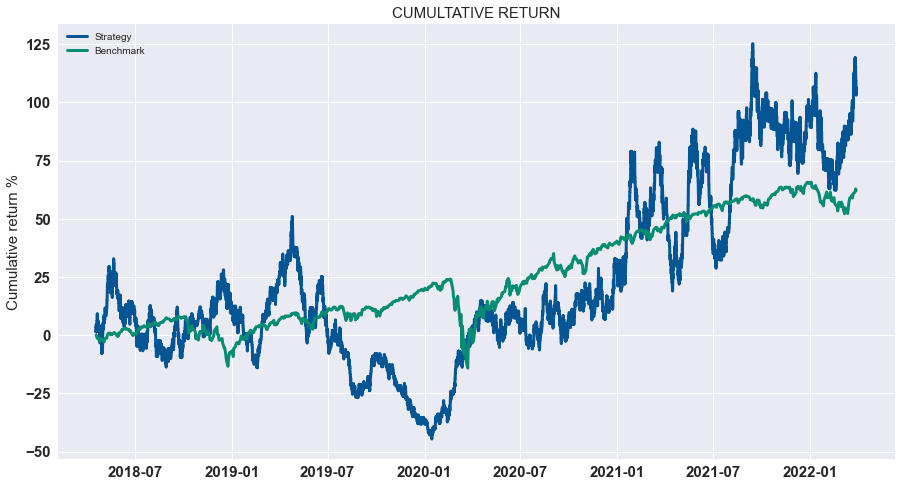

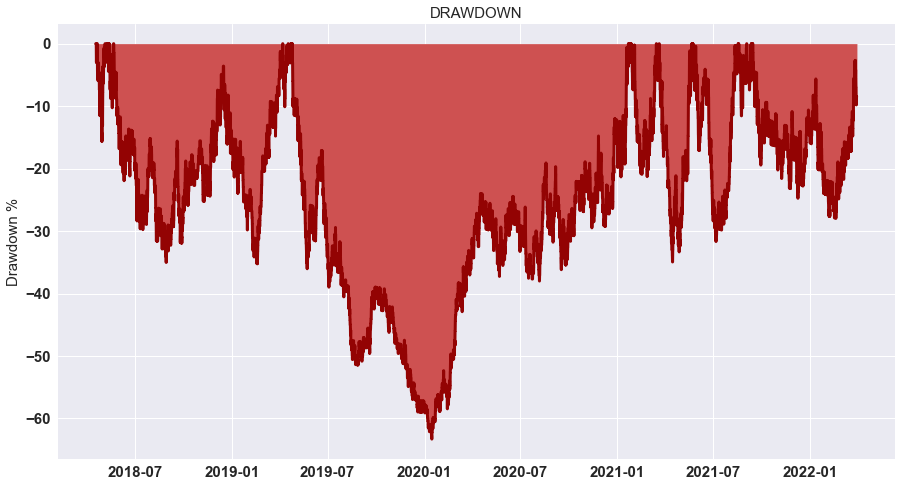

In [8]:
backtest_tpsl_portfolio(df)

In [9]:
# Bonus
def profitable_month_return(p):
    total = 0
    positif = 0


    r=[]
    # Loop on each different year
    for year in p.index.strftime("%y").unique():
        e = []
        nbm = p.loc[p.index.strftime("%y")==year].index.strftime("%m").unique()
        # Loop on each different month
        for mois in nbm:

            monthly_values =  p.loc[p.index.strftime("%y:%m")==f"{year}:{mois}"]
            sum_ = monthly_values.sum()

            # Verifying that there is at least 75% of the values
            if len(monthly_values)>15:

                # Computing sum return
                s = monthly_values.sum()

                if s>0:
                    positif+=1

                else:
                    pass

                total+=1

            else:
                pass
            e.append(sum_)
        r.append(e)




    r[0]=[0 for _ in range(12-len(r[0]))] + r[0]
    r[-1]= r[-1]  + [0 for _ in range(12-len(r[-1]))] 
    return pd.DataFrame(r,columns=["January","February","March","April","May","June",
                                  "July","August","September","October","November","December"], index=p.index.strftime("%y").unique())

def heatmap(data):
    htm = profitable_month_return(data["returns"])*100
    htm.index.name = "Year"
    htm.index = [f"20{idx}" for idx in htm.index]

    plt.figure(figsize=(20,8))
    pal = sns.color_palette("RdYlGn",n_colors=15)
    sns.heatmap(htm, annot=True, cmap =pal, vmin=-100, vmax=100)
    
    plt.title("Heatmap Monthly returns")
    plt.show()

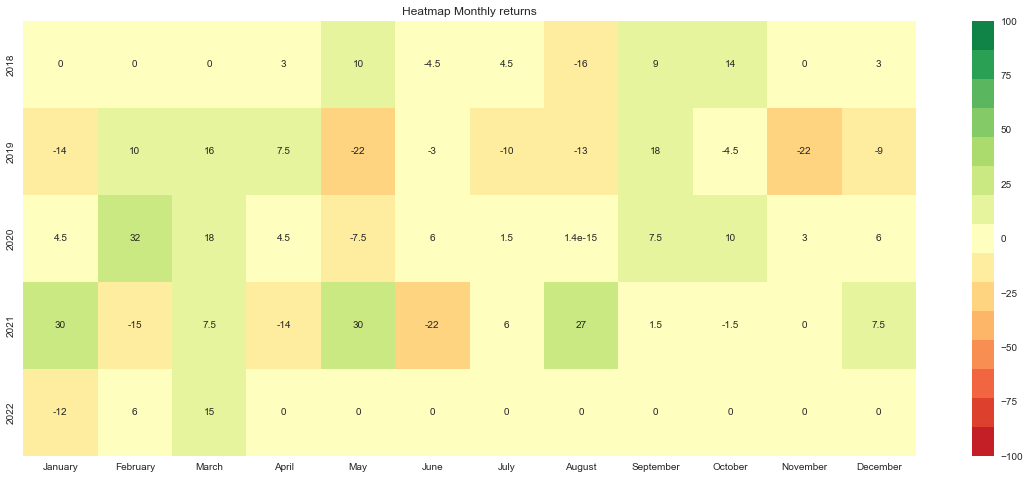

In [10]:
heatmap(df)

### 6.3 Advanced backtest tools

###### 6.3.2 Monte Carlo simulation

100%|█████████████████████████████████████████| 100/100 [00:37<00:00,  2.67it/s]


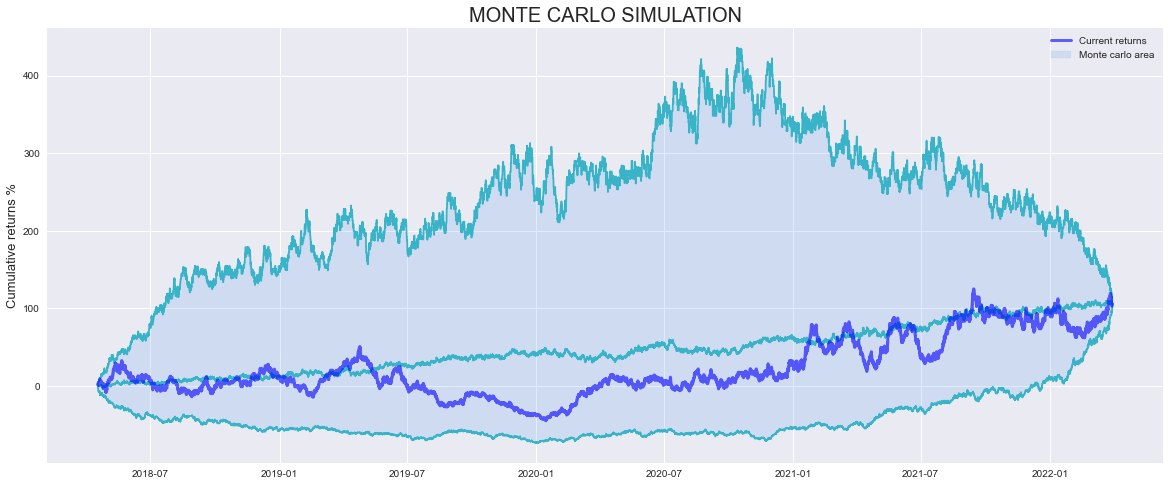

In [11]:
def monte_carlo(data, method="simple"):
    random_returns = []
    data["returns"] = data["returns"].fillna(value=0)

    for _ in tqdm(range(100)):
        returns = data["returns"]-10**-100
        np.random.shuffle(returns)
        random_returns.append(returns)

    if method=="simple":
        df_ret = pd.DataFrame(random_returns).transpose().cumsum()*100
        cur_ret = data["returns"].cumsum()*100
    else:
        df_ret = ((1+pd.DataFrame(random_returns).transpose()).cumprod()-1)*100
        cur_ret = ((1+data["returns"]).cumprod()-1)*100

    p_90 = np.percentile(df_ret, 99, axis=1)
    p_50 = np.percentile(df_ret, 50, axis=1)
    p_10 = np.percentile(df_ret, 1, axis=1)



    plt.figure(figsize=(20,8))

    plt.plot(df_ret.index, p_90, color="#39B3C7")
    plt.plot(df_ret.index, p_50, color="#39B3C7")
    plt.plot(df_ret.index, p_10, color="#39B3C7")

    plt.plot(cur_ret, color="blue", alpha=0.60, linewidth=3, label="Current returns")


    plt.fill_between(df_ret.index, p_90, p_10,
                        p_90>p_10, color="#669FEE", alpha=0.20, label="Monte carlo area")


    plt.ylabel("Cumulative returns %", size=13)
    plt.title("MONTE CARLO SIMULATION", size=20)

    plt.legend()
    plt.show()
    
monte_carlo(df, method="compounded")

100%|█████████████████████████████████████████| 100/100 [00:37<00:00,  2.68it/s]


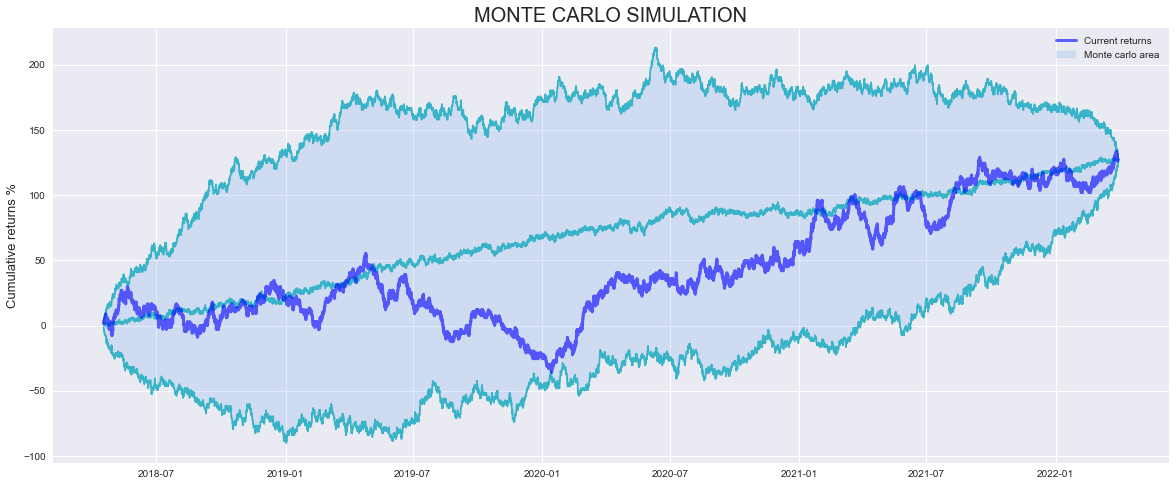

In [14]:
monte_carlo(df, method="simple")

###### 6.3.3 Easy Trailing stop

In [12]:
def run_tsl(data, leverage=1, tp=0.015, sl=-0.015, tsl= 0.001, cost=0.00):
    """
    :params (mandatory): data(have to contain a High_time and a Low_time columns)
    :params (optional): leverage=1, tp=0.015, sl=-0.015, cost=0.00
    :return: data with three new columns: Low_time (TimeStamp), High_time (TimeStamp), High_first (Boolean)
    """
    tpl = tp - tsl
    
    # Set some parameters
    buy=False
    sell=False
    data["duration"] = 0
    

    for i in range(len(data)):

        # Extract data
        row = data.iloc[i]


        ######## OPEN BUY ########
        if buy==False and row["Signal"]==1:
            buy = True
            open_buy_price = row["open"]
            open_buy_date = row.name

        #VERIF
        if buy:
            var_buy_high = (row["high"] - open_buy_price) / open_buy_price
            var_buy_low = (row["low"] - open_buy_price) / open_buy_price

            # VERIF FOR TP AND SL ON THE SAME CANDLE
            if (var_buy_high > tp) and (var_buy_low < sl):

                # IF TP / SL ON THE SAME TIMESTAMP, WE DELETE THE TRADE RETURN
                if row["Low_time"] == row["High_time"]:
                    pass
                
                elif row["First"]==2: 
                    data.loc[row.name, "returns"] = (tpl-cost) * leverage
                    data.loc[row.name, "duration"] = row.High_time - open_buy_date

                elif row["First"]==1:
                    data.loc[row.name, "returns"] = (sl-cost) * leverage
                    data.loc[row.name, "duration"] = row.Low_time - open_buy_date

                buy = False
                open_buy_price = None
                var_buy_high = 0
                var_buy_low = 0
                open_buy_date = None

            elif var_buy_high > tp:
                data.loc[row.name, "returns"] = (tpl-cost) * leverage
                buy = False
                open_buy_price = None
                var_buy_high = 0
                var_buy_low = 0
                data.loc[row.name, "duration"] = row.High_time - open_buy_date
                open_buy_date = None
                
            elif var_buy_low < sl:
                data.loc[row.name, "returns"] = (sl-cost) * leverage
                buy = False
                open_buy_price = None
                var_buy_high = 0
                var_buy_low = 0
                data.loc[row.name, "duration"] = row.Low_time - open_buy_date
                open_buy_date = None

                
        ######## OPEN SELL ########
        if sell==False and row["Signal"]==-1:
            sell = True
            open_sell_price = row["open"]
            open_sell_date = row.name

        #VERIF
        if sell:
            var_sell_high = -(row["high"] - open_sell_price) / open_sell_price
            var_sell_low = -(row["low"] - open_sell_price) / open_sell_price

            if (var_sell_low > tp) and (var_sell_high < sl):

                if row["Low_time"] == row["High_time"]:
                    pass
                elif row["First"]==1: #À INVERSER POUR LE BUY
                    data.loc[row.name, "returns"] = (tpl-cost) * leverage
                    data.loc[row.name, "duration"] = row.Low_time - open_sell_date

                elif row["First"]==2:
                    data.loc[row.name, "returns"] = (sl-cost) * leverage
                    data.loc[row.name, "duration"] = row.High_time - open_sell_date

                sell = False
                open_sell_price = None
                var_sell_high = 0
                var_sell_low = 0
                open_sell_date = None

            elif var_sell_low > tp: 
                data.loc[row.name, "returns"] = (tpl-cost) * leverage
                sell = False
                open_sell_price = None
                var_sell_high = 0
                var_sell_low = 0
                data.loc[row.name, "duration"] = row.Low_time - open_sell_date
                open_sell_date = None


            elif var_sell_high < sl:
                data.loc[row.name, "returns"] = (sl-cost) * leverage
                sell = False
                open_sell_price = None
                var_sell_high = 0
                var_sell_low = 0
                data.loc[row.name, "duration"] = row.High_time - open_sell_date
                open_sell_date = None
    return data

In [13]:
run_tsl(df)

,timestamp,open,high,low,close,volume,Low_time,High_time,First,Signal,duration,returns
Time,,,,,,,,,,,,
2018-04-17 04:00:00,2018-04-17 04:00:00,0.25551,0.28800,0.25551,0.26664,8143693.23,2018-04-17 04:00:00,2018-04-17 04:05:00,1.0,1,0 days 00:05:00,0.014
2018-04-17 05:00:00,2018-04-17 05:00:00,0.26660,0.27798,0.26010,0.26200,8317923.61,2018-04-17 05:55:00,2018-04-17 05:05:00,2.0,0,0,0.000
2018-04-17 06:00:00,2018-04-17 06:00:00,0.26221,0.26396,0.24800,0.25664,8420095.41,2018-04-17 06:30:00,2018-04-17 06:00:00,2.0,0,0,0.000
2018-04-17 07:00:00,2018-04-17 07:00:00,0.25662,0.26300,0.25489,0.25698,4686043.91,2018-04-17 07:00:00,2018-04-17 07:30:00,1.0,1,0 days 00:30:00,0.014
2018-04-17 08:00:00,2018-04-17 08:00:00,0.25636,0.25998,0.25229,0.25631,3510038.13,2018-04-17 08:10:00,2018-04-17 08:40:00,1.0,0,0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-30 19:00:00,2022-03-30 19:00:00,1.19800,1.20300,1.18300,1.19300,10494867.40,2022-03-30 19:50:00,2022-03-30 19:10:00,2.0,0,0,0.000
2022-03-30 20:00:00,2022-03-30 20:00:00,1.19400,1.20200,1.19000,1.20100,4851374.00,2022-03-30 20:00:00,2022-03-30 20:50:00,1.0,1,0,0.000
2022-03-30 21:00:00,2022-03-30 21:00:00,1.20200,1.20200,1.18800,1.19200,3691192.60,2022-03-30 21:55:00,2022-03-30 21:00:00,2.0,0,0,0.000


[*********************100%***********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Beta: -0.018 	 Alpha: -3.13 %	     AVERAGE TRADE LIFETIME: 3H 11min
    -----------------------------------------------------------------------------
    VaR: 1.32 %	 cVaR: 1.5 % 	     TUW: 99.71%  	 drawdown: 87.8 %
    -----------------------------------------------------------------------------


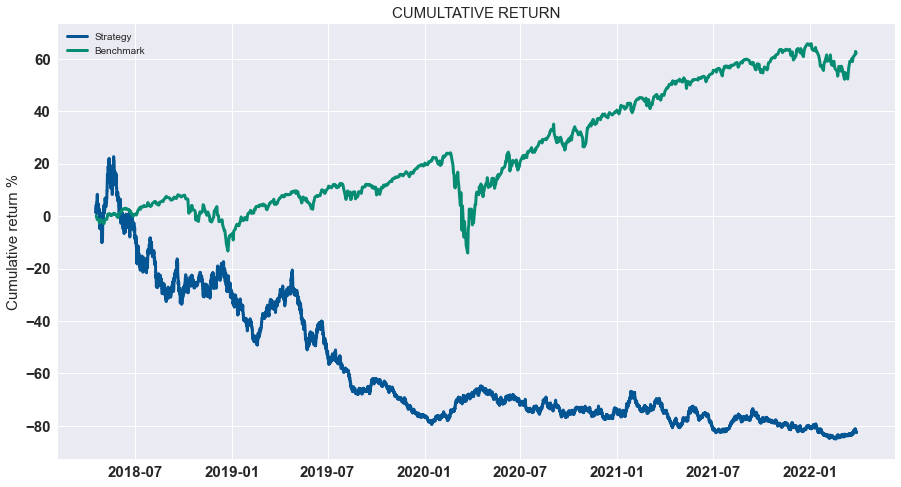

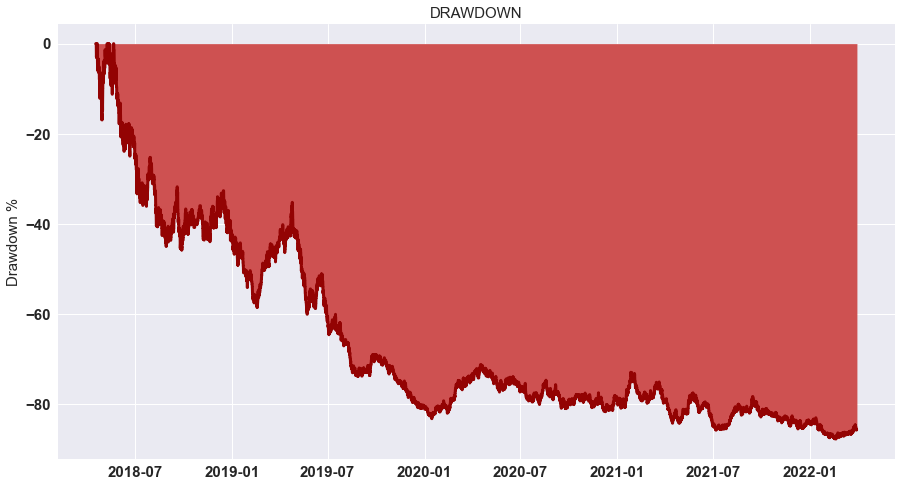

In [14]:
backtest_tpsl_portfolio(df)